In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn import preprocessing
import importlib
import gomokutrainer
import onnx
import keras2onnx
import matplotlib.pyplot as plt
from os import path
from datetime import datetime


In [8]:
data_raw = pd.concat([
    #pd.read_csv("C:\\Projects\\TrainDatasetGenerator\\2021-05-03_16-37-56.csv", header=None, sep=';', decimal=","),
    #pd.read_csv("C:\\Projects\\TrainDatasetGenerator\\2021-05-03_16-38-01.csv", header=None, sep=';', decimal=","),
    #pd.read_csv("C:\\Projects\\TrainDatasetGenerator\\2021-05-05_09-26-20.csv", header=None, sep=';', decimal=","),
    pd.read_csv("C:\\Projects\\TrainDatasetGenerator\\I30000_MEC1000_05-06_10-36-25.csv", header=None, sep=';', decimal=",")
], ignore_index = True)
##Reverse first player evaluations
#print("before \n", data_raw[lambda x: x[450] == 1])
data_raw.loc[lambda x: x[450] == 1,452] = data_raw.loc[lambda x: x[450] == 1,452].apply(lambda x: x*-1)
#print("after \n", data_raw[lambda x: x[450] == 1])
input_slice = range(450)

data_train = data_raw[data_raw.index % 20 != 0].reset_index(drop = True)
data_validation = data_raw[data_raw.index % 20 == 0].reset_index(drop = True)

data_train_x = data_train[input_slice].to_numpy()
data_validation_x = data_validation[input_slice].to_numpy()

data_train_y = data_train[[452]].to_numpy()
data_validation_y = data_validation[[452]].to_numpy()

print(f"data_train_x ({len(data_train_x)}) \n", data_train_x)
print(f"data_train_y ({len(data_train_y)}) \n", data_train_y)
print(f"data_validation_x ({len(data_validation_x)}) \n", data_validation_x)
print(f"data_validation_y ({len(data_validation_y)}) \n", data_validation_y)

data_train_x (67045) 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
data_train_y (67045) 
 [[0.05468103]
 [0.0682913 ]
 [0.07688869]
 ...
 [0.05500594]
 [0.06369221]
 [0.06854029]]
data_validation_x (3529) 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
data_validation_y (3529) 
 [[0.05716407]
 [0.07768187]
 [0.06479082]
 ...
 [1.        ]
 [0.07401813]
 [0.10795455]]


In [3]:
#importlib.reload(gomokutrainer)
#from gomokutrainer import create_model
#model = create_model()
input_shape = (15,15,2)
input_len = input_shape[0] * input_shape[1] * input_shape[2]
"""model = keras.Sequential(
    [
      keras.Input(shape=input_len, name="input"),

      layers.Reshape(input_shape),

      layers.Conv2D(32, kernel_size=(3, 3),
        kernel_initializer=keras.initializers.HeNormal()),
      layers.LeakyReLU(alpha=0.2),

      layers.Conv2D(64, kernel_size=(3, 3),
        kernel_initializer=keras.initializers.HeNormal()),
      layers.LeakyReLU(alpha=0.2),

      layers.Conv2D(128, kernel_size=(3, 3),
        kernel_initializer=keras.initializers.HeNormal()),
      layers.LeakyReLU(alpha=0.2),

      layers.Flatten(),

      layers.Dropout(0.5),

      layers.Dense(128,
        kernel_initializer=keras.initializers.HeNormal()),
      layers.LeakyReLU(alpha=0.2),

      layers.Dense(64,
        kernel_initializer=keras.initializers.HeNormal()),
      layers.LeakyReLU(alpha=0.2),

      layers.Dense(32,
        kernel_initializer=keras.initializers.HeNormal()),
      layers.LeakyReLU(alpha=0.2),

      layers.Dense(1, activation='tanh', name="output")
    ]
  )
  """

model = keras.Sequential(
  [
    keras.Input(shape=input_len, name="input"),

    layers.Reshape(input_shape),

    layers.Conv2D(32, kernel_size=(3, 3), kernel_initializer='lecun_normal', activation='selu'),

    layers.Conv2D(64, kernel_size=(3, 3), kernel_initializer='lecun_normal', activation='selu'),

    layers.Flatten(),

    layers.Dropout(0.5),

    layers.Dense(64, kernel_initializer='lecun_normal', activation='selu'),

    layers.Dense(32, kernel_initializer='lecun_normal', activation='selu'),

    layers.Dense(1, activation='tanh', name="output")
  ]
)
model.compile(tf.optimizers.RMSprop(0.001), loss='mse', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 15, 15, 2)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 13, 13, 32)        608       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0         
_________________________________________________________________
dropout (Dropout)            (None, 7744)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                495680    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2

In [9]:
history = model.fit(data_train_x, data_train_y, epochs=30, batch_size=5000, validation_data=(data_validation_x, data_validation_y))

predictions = model.predict(data_validation_x)

Epoch 1/30
14/14 [==============================] - 11s 810ms/step - loss: 0.0193 - mse: 0.0193 - val_loss: 0.0184 - val_mse: 0.0184
Epoch 2/30
14/14 [==============================] - 12s 826ms/step - loss: 0.0184 - mse: 0.0184 - val_loss: 0.0291 - val_mse: 0.0291
Epoch 3/30
14/14 [==============================] - 12s 874ms/step - loss: 0.0667 - mse: 0.0667 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 4/30
14/14 [==============================] - 12s 827ms/step - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0135 - val_mse: 0.0135
Epoch 5/30
14/14 [==============================] - 13s 902ms/step - loss: 0.0135 - mse: 0.0135 - val_loss: 0.0122 - val_mse: 0.0122
Epoch 6/30
14/14 [==============================] - 12s 826ms/step - loss: 0.0221 - mse: 0.0221 - val_loss: 0.0583 - val_mse: 0.0583
Epoch 7/30
14/14 [==============================] - 11s 803ms/step - loss: 0.0231 - mse: 0.0231 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 8/30
14/14 [==============================] - 11s 800ms/step - 

minimal validation loss = 0.006191144697368145


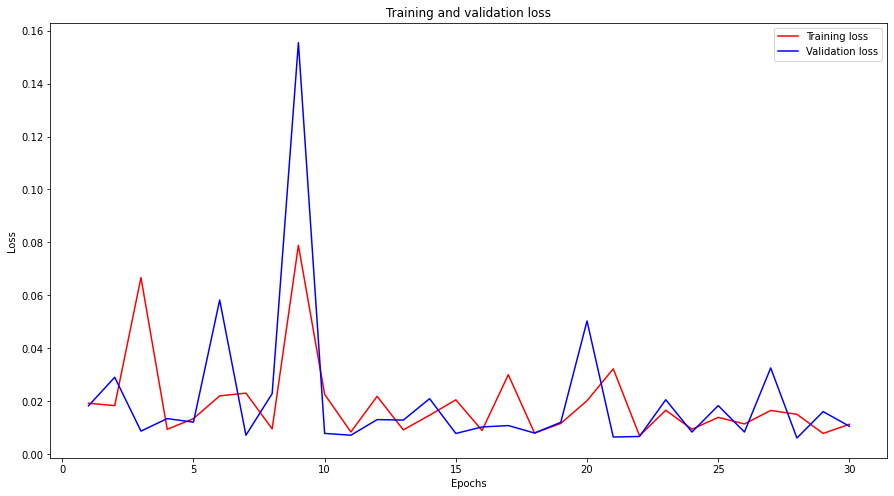

In [10]:

history.history.keys()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(15,8))
plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

print(f'minimal validation loss = {min(val_loss)}' )

maximal validation accuracy = 0.6112632155418396


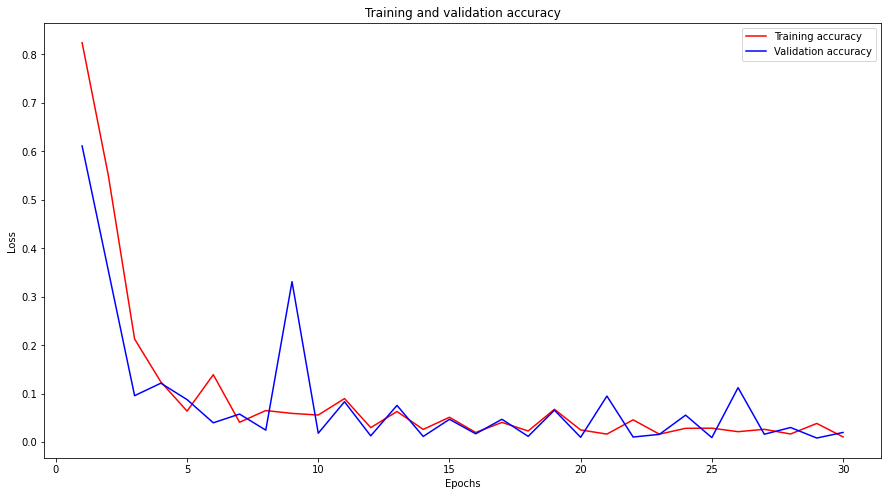

In [6]:
history.history.keys()
accuracy = history.history['mse']
val_accuracy = history.history['val_mse']
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(15,8))
plt.plot(epochs, accuracy, 'r', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

print(f'maximal validation accuracy = {max(val_accuracy)}' )

In [8]:
output_path = path.join("C:\\","Projects","TrainDatasetGenerator","TrainedModels", datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
model.save(path.join(output_path,"keras-model"))
onnx_model = keras2onnx.convert_keras(model, "model.onnx")
onnx.save_model(onnx_model, path.join(output_path, "model.onnx"))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Projects\TrainDatasetGenerator\TrainedModels\2021-05-05_19-04-42\keras-model\assets
tf executing eager_mode: True
tf.keras model eager_mode: False
The ONNX operator number change on the optimization: 28 -> 15
